In [46]:
#%% ============== Import libraries =========
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from pandas.core.dtypes.common import is_numeric_dtype, is_string_dtype
from scipy import stats
from sklearn import linear_model
from yellowbrick.regressor import ResidualsPlot
import statsmodels.formula.api as smf
import my_functions as mf

warnings.filterwarnings('ignore')  # it is used for some minor warnings in seaborn

In [47]:

vif_features = True  # if only we want to run features with vif < 20
network = False

In [48]:
# %% ============= Load the Data ============================================================

df = mf.load_data(f'datasets/paas_data.csv')
uniqueList = tuple((column,) for column in df)
for column in df:
    print(df[column].value_counts())

Microsoft    282
Google       270
Amazon       254
Name: Provider, dtype: int64
0.061836    2
0.801369    2
1.001369    2
0.501369    2
0.360958    2
           ..
0.516233    1
0.666233    1
0.216233    1
0.372260    1
1.462055    1
Name: Price, Length: 760, dtype: int64
WebApp    806
Name: Deployment Type, dtype: int64
2    319
4    245
1    146
8     96
Name: CPU, dtype: int64
8.00     114
32.00    113
2.00     105
7.00      94
16.00     92
1.00      70
0.50      69
3.50      55
1.75      35
14.00     35
4.00      24
Name: RAM, dtype: int64
250     204
1000    195
50      164
10      145
500      98
Name: STORAGE, dtype: int64
400     213
2000    212
1000    207
4000    169
300       5
Name: external_egress, dtype: int64
400     183
1000    173
100     154
2000    153
600     142
0         1
Name: internal_egress, dtype: int64
yes    722
no      84
Name: Autoscaling, dtype: int64
0    544
1    131
3    131
Name: Term_Length, dtype: int64
A_Shared     466
Dedicated    244
Isolated   

In [49]:
# # Select provider 
cloudProvider = 'Google'
df = df.loc[df['Provider'] == cloudProvider]
df

,Provider,Price,Deployment Type,CPU,RAM,STORAGE,external_egress,internal_egress,Autoscaling,Term_Length,Instance_Type,OS,Region,Scaling_to_zero,AppService_Domain,Certificates,Regional_Redudancy,Container_support
282,Google,0.178767,WebApp,1,0.5,50,400,400,no,0,A_Shared,Windows,US,yes,yes,A_no,yes,no
283,Google,0.278767,WebApp,2,1.0,50,400,400,no,0,A_Shared,Windows,US,yes,yes,A_no,yes,no
284,Google,0.378767,WebApp,2,2.0,50,400,400,no,0,A_Shared,Windows,US,yes,yes,A_no,yes,no
285,Google,0.478767,WebApp,4,2.0,50,400,400,no,0,A_Shared,Windows,US,yes,yes,A_no,yes,no
286,Google,0.178767,WebApp,1,0.5,50,400,400,yes,0,A_Shared,Windows,US,yes,yes,A_no,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,Google,1.277068,WebApp,2,7.0,500,4000,600,yes,0,A_Shared,Windows,Australia,no,no,A_no,yes,yes
548,Google,1.494548,WebApp,4,14.0,500,4000,1000,yes,0,A_Shared,Windows,Australia,no,no,A_no,yes,yes
549,Google,1.292548,WebApp,2,8.0,500,4000,1000,yes,0,A_Shared,Windows,Australia,no,no,A_no,yes,yes
550,Google,1.514548,WebApp,4,16.0,500,4000,1000,yes,0,A_Shared,Windows,Australia,no,no,A_no,yes,yes


In [50]:
# %% ============= Dataframe Checks before regression ============================================================

mf.dataframe_info(df)  # print some info about df
mf.check_null(df)  # check for null values in the dataframe.

# mf.visualize_data(df)


# %% TODO: for loop to identify th unique values
# columnLength: list = df.shape[1]
# uniqueList: list = []
#
# for x in columnLength:
#     uniqueList = df.iloc[:, x]
if network:
    df.drop(columns=['Provider', 'Deployment Type'], axis=1, inplace=True)
else:
    df.drop(columns=['Provider', 'Deployment Type', 'internal_egress', 'external_egress'], axis=1, inplace=True)

# %% Map binary categorical columns to numerical

categorical_binary = ['Autoscaling', 'Scaling_to_zero', 'AppService_Domain', 'Regional_Redudancy', 'Container_support']

df[categorical_binary] = df[categorical_binary].apply(mf.binary_map)

# Map>3 categorical columns to numerical

# Write the categorical values as a list
categorical = ['Instance_Type', 'Region', 'Certificates', 'OS']
categorical2numeric = pd.get_dummies(df[categorical], drop_first=True, sparse=False)

# Add the above results to the original dataframe df
df = pd.concat([df, categorical2numeric], axis=1)
df.drop(columns=categorical, axis=1, inplace=True)
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270 entries, 282 to 551
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Provider            270 non-null    object 
 1   Price               270 non-null    float64
 2   Deployment Type     270 non-null    object 
 3   CPU                 270 non-null    int64  
 4   RAM                 270 non-null    float64
 5   STORAGE             270 non-null    int64  
 6   external_egress     270 non-null    int64  
 7   internal_egress     270 non-null    int64  
 8   Autoscaling         270 non-null    object 
 9   Term_Length         270 non-null    int64  
 10  Instance_Type       270 non-null    object 
 11  OS                  270 non-null    object 
 12  Region              270 non-null    object 
 13  Scaling_to_zero     270 non-null    object 
 14  AppService_Domain   270 non-null    object 
 15  Certificates        270 non-null    object 
 16  Region

,Price,CPU,RAM,STORAGE,Autoscaling,Term_Length,Scaling_to_zero,AppService_Domain,Regional_Redudancy,Container_support,Region_Asia,Region_Australia,Region_South America,Region_US
282,0.178767,1,0.5,50,0,0,1,1,1,0,0,0,0,1
283,0.278767,2,1.0,50,0,0,1,1,1,0,0,0,0,1
284,0.378767,2,2.0,50,0,0,1,1,1,0,0,0,0,1
285,0.478767,4,2.0,50,0,0,1,1,1,0,0,0,0,1
286,0.178767,1,0.5,50,1,0,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,1.277068,2,7.0,500,1,0,0,0,1,1,0,1,0,0
548,1.494548,4,14.0,500,1,0,0,0,1,1,0,1,0,0
549,1.292548,2,8.0,500,1,0,0,0,1,1,0,1,0,0
550,1.514548,4,16.0,500,1,0,0,0,1,1,0,1,0,0


In [51]:
# %% =============== Log transformation ======================================

# # choose all cols after encoding (dummy)
# col2log = list(df.columns.values)
# col2log


# choose specific Columns with numerical values to change scale
col2log = []
if network:
    col2log = ['Price', 'CPU', 'RAM', 'STORAGE', 'external_egress', 'internal_egress', 'Term_Length']
else:
    col2log = ['Price', 'CPU', 'RAM', 'STORAGE', 'Term_Length']
               # 'Autoscaling', 'Scaling_to_zero', 'OS', 'AppService_Domain',
               # 'Regional_redundancy', 'Container_support']

# for column in df:
#     df[column] = df[column].astype(int)



In [52]:
df[col2log] = np.log10(df[col2log] + 1)
df[col2log].replace([col2log], inplace=True)

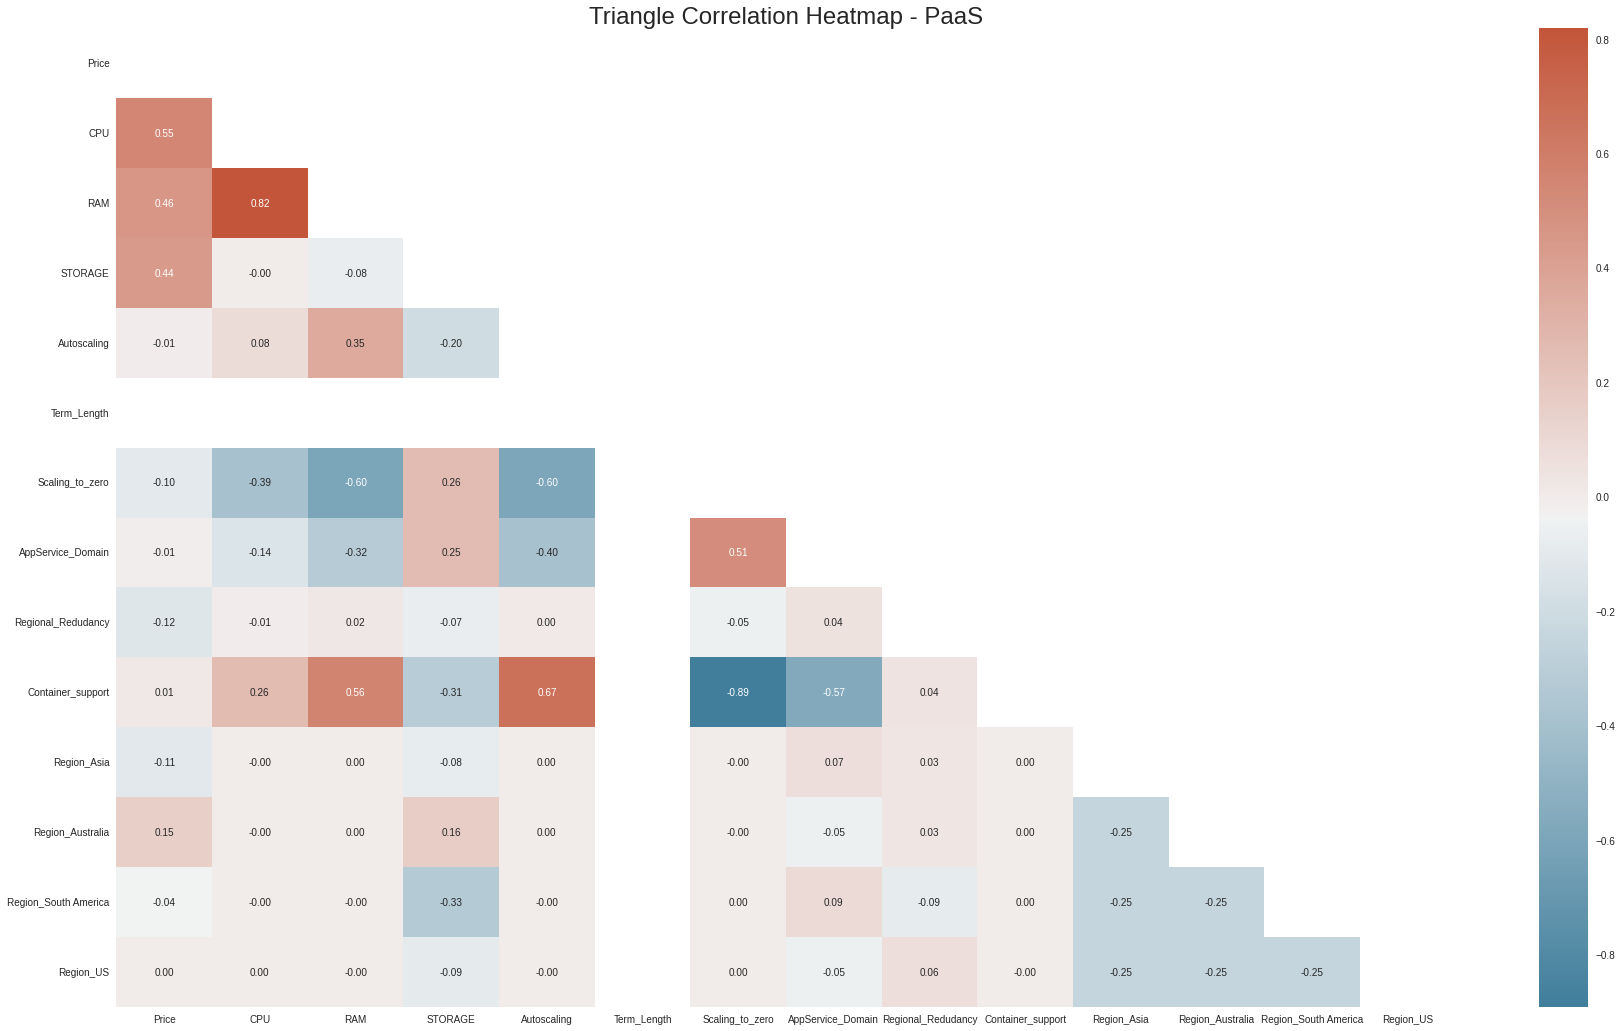

In [53]:
# %% ===================== Correlation ===========================
# Check the correlation coefficients to see which variables are highly correlated
correlation_method: str = 'pearson'

corr = df.corr(method=correlation_method)
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(30, 18))
heatmap = sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, fmt=".2f")
heatmap.set_title(f"Triangle Correlation Heatmap - PaaS", fontdict={'fontsize': 24}, pad=1)
plt.savefig('plots/paas_heatmap_triangle.png')
plt.show()



In [54]:

# %% ===================== Model Evaluation ===========================
y = df.Price
x = df.drop('Price', axis=1)

mf.model_evaluation(x, y)
model = linear_model.LinearRegression()



======== TRAIN dataset - 80% ===========
Coefficients:
 [ 2.37039678e-01  2.68107888e-02  6.53078867e-02  1.66902107e-02
  3.16587034e-17  1.63440664e-02 -2.27138054e-02 -8.78514493e-03
 -5.30510832e-03  3.39717408e-02  4.19917878e-02  5.99988718e-02
  4.45514466e-02]
Intercept: -0.10582183940879725
Mean squared error (MSE): 0.004
Coefficient of determination (R^2): 0.539


========= TEST dataset - 20% ===========
Coefficients:
 [ 2.37039678e-01  2.68107888e-02  6.53078867e-02  1.66902107e-02
  3.16587034e-17  1.63440664e-02 -2.27138054e-02 -8.78514493e-03
 -5.30510832e-03  3.39717408e-02  4.19917878e-02  5.99988718e-02
  4.45514466e-02]
Intercept: -0.10582183940879725
Mean squared error (MSE): 0.004
Coefficient of determination (R^2): 0.583



In [55]:
# %% =================== Calculate VIF Factors =====================

# vif = mf.vif_calc(x)

# # %%  =================== Drop columns after vif/reg calculation =====================
# if vif_features:
#     good_vif = vif[vif['VIF Factor'] < 20]
#     drop_after_vif = good_vif['features'].tolist()
#     df_new = df[drop_after_vif]
#     price = df['Price']
#     df_new = df_new.join(price)
#     df = df_new
#     # Re-assign x, y for regression
#     y = df.Price
#     x = df.drop('Price', axis=1)
#     good_vif.to_csv(f'results/term/paas_vif_net_{network}.csv', index=False)
# else:
#     vif.to_csv(f'results/term/paas_good_vif_net_{network}.csv', index=False)


In [56]:
x

,CPU,RAM,STORAGE,Autoscaling,Term_Length,Scaling_to_zero,AppService_Domain,Regional_Redudancy,Container_support,Region_Asia,Region_Australia,Region_South America,Region_US
282,0.301030,0.176091,1.707570,0,0.0,1,1,1,0,0,0,0,1
283,0.477121,0.301030,1.707570,0,0.0,1,1,1,0,0,0,0,1
284,0.477121,0.477121,1.707570,0,0.0,1,1,1,0,0,0,0,1
285,0.698970,0.477121,1.707570,0,0.0,1,1,1,0,0,0,0,1
286,0.301030,0.176091,1.707570,1,0.0,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,0.477121,0.903090,2.699838,1,0.0,0,0,1,1,0,1,0,0
548,0.698970,1.176091,2.699838,1,0.0,0,0,1,1,0,1,0,0
549,0.477121,0.954243,2.699838,1,0.0,0,0,1,1,0,1,0,0
550,0.698970,1.230449,2.699838,1,0.0,0,0,1,1,0,1,0,0


In [57]:
# x = sm.add_constant(x)
x['const'] = 1
x

,CPU,RAM,STORAGE,Autoscaling,Term_Length,Scaling_to_zero,AppService_Domain,Regional_Redudancy,Container_support,Region_Asia,Region_Australia,Region_South America,Region_US,const
282,0.301030,0.176091,1.707570,0,0.0,1,1,1,0,0,0,0,1,1
283,0.477121,0.301030,1.707570,0,0.0,1,1,1,0,0,0,0,1,1
284,0.477121,0.477121,1.707570,0,0.0,1,1,1,0,0,0,0,1,1
285,0.698970,0.477121,1.707570,0,0.0,1,1,1,0,0,0,0,1,1
286,0.301030,0.176091,1.707570,1,0.0,1,1,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,0.477121,0.903090,2.699838,1,0.0,0,0,1,1,0,1,0,0,1
548,0.698970,1.176091,2.699838,1,0.0,0,0,1,1,0,1,0,0,1
549,0.477121,0.954243,2.699838,1,0.0,0,0,1,1,0,1,0,0,1
550,0.698970,1.230449,2.699838,1,0.0,0,0,1,1,0,1,0,0,1


In [58]:

# %%============ Detailed calculation for statistical metrics with OLS (Ordinary Least Squares) ==============

# mf.ols_regression(x, y)

model_sm = sm.OLS(y, x)
# model_sm = smf.ols(formula='y ~ x', data=df)
results = model_sm.fit()
print(results.summary())
print(results.params)
metrics = pd.read_html(results.summary().tables[0].as_html(), header=0, index_col=0)[0]
coefficients = pd.read_html(results.summary().tables[1].as_html(), header=0, index_col=0)[0]

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     26.71
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           1.17e-38
Time:                        11:59:59   Log-Likelihood:                 378.93
No. Observations:                 270   AIC:                            -731.9
Df Residuals:                     257   BIC:                            -685.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
CPU                      0.2117 

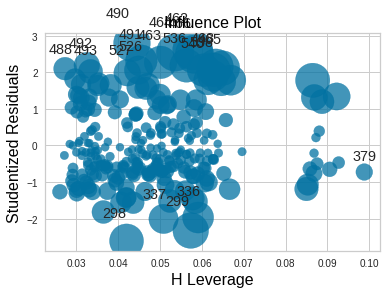

In [59]:
# %%========== Export OLS results =========
metrics = pd.read_html(results.summary().tables[0].as_html(), header=0, index_col=0)[0]
coefficients = pd.read_html(results.summary().tables[1].as_html(), header=0, index_col=0)[0]
metrics.to_csv(f'results/paas_metrics_{cloudProvider}.csv', index=True)
coefficients.to_csv(f'results/paas_coeff_{cloudProvider}.csv', index=True)
# %%
sm.graphics.influence_plot(results, size=40, criterion='cooks', plot_alpha=0.75, ax=None)
plt.show()


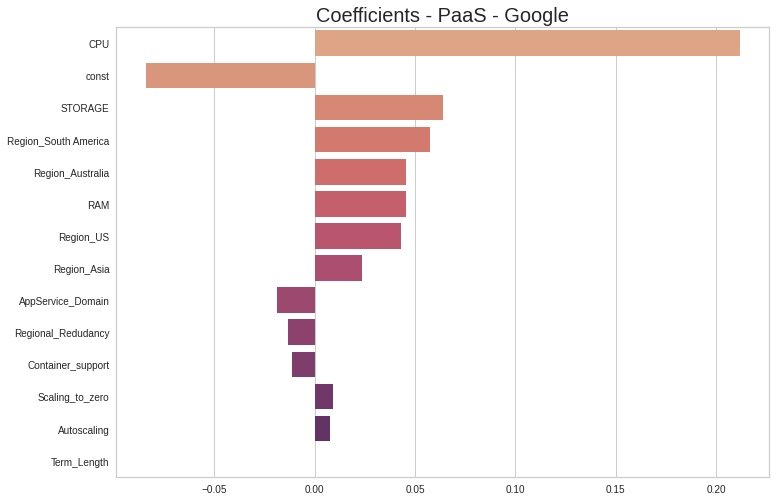

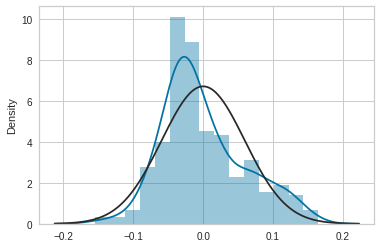

In [60]:

# %% ======================== Tornado diagram ======================================
coeff = results.params
coeff = coeff.iloc[(coeff.abs() * -1.0).argsort()]
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(coeff.values, coeff.index, orient='h', ax=ax, palette="flare", capsize=None)
plt.title(f'Coefficients - PaaS - {cloudProvider}', size=20)
plt.savefig(f'plots/paas_coeff_tornado_{cloudProvider}.png')
plt.show()
# %%
sns.distplot(results.resid, fit=stats.norm, hist=True)
plt.show()

In [61]:


# ================= Selection of features by P-value ===========================

coeff_results = mf.load_data(f'results/paas_coeff_{cloudProvider}.csv')
coeff_results.rename(columns={'Unnamed: 0': 'Feature'}, inplace=True)

significant = coeff_results[coeff_results['P>|t|'] < 0.05]

features_list = significant['Feature'].tolist()
features_list.remove('const')
# features_list.remove('AppService_Domain')
features_list.insert(0, 'Price')

# features_list.insert(0, 'RAM')

df = df[features_list]
df

,Price,CPU,RAM,STORAGE,Region_Australia,Region_South America,Region_US
282,0.071428,0.301030,0.176091,1.707570,0,0,1
283,0.106791,0.477121,0.301030,1.707570,0,0,1
284,0.139491,0.477121,0.477121,1.707570,0,0,1
285,0.169900,0.698970,0.477121,1.707570,0,0,1
286,0.071428,0.301030,0.176091,1.707570,0,0,1
...,...,...,...,...,...,...,...
547,0.357376,0.477121,0.903090,2.699838,1,0,0
548,0.396992,0.698970,1.176091,2.699838,1,0,0
549,0.360318,0.477121,0.954243,2.699838,1,0,0
550,0.400460,0.698970,1.230449,2.699838,1,0,0


In [62]:

# %%============  2nd Detailed calculation for statistical metrics with OLS (Ordinary Least Squares) ==============

y = df.Price
x = df.drop('Price', axis=1)

# mf.ols_regression(x, y)
x = sm.add_constant(x)
model_sm = sm.OLS(y,x)
results = model_sm.fit()
print(results.summary())
print(results.params)
metrics_sign = pd.read_html(results.summary().tables[0].as_html(), header=0, index_col=0)[0]
coefficients_sign = pd.read_html(results.summary().tables[1].as_html(), header=0, index_col=0)[0]

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     50.84
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           2.72e-41
Time:                        12:00:00   Log-Likelihood:                 373.59
No. Observations:                 270   AIC:                            -733.2
Df Residuals:                     263   BIC:                            -708.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0723 

In [63]:

# %% ========== Export OLS results =========

metrics.to_csv(f'results/paas_significant_metrics_{cloudProvider}.csv', index=True)
coefficients.to_csv(f'results/paas_significant_coeff_{cloudProvider}.csv', index=True)

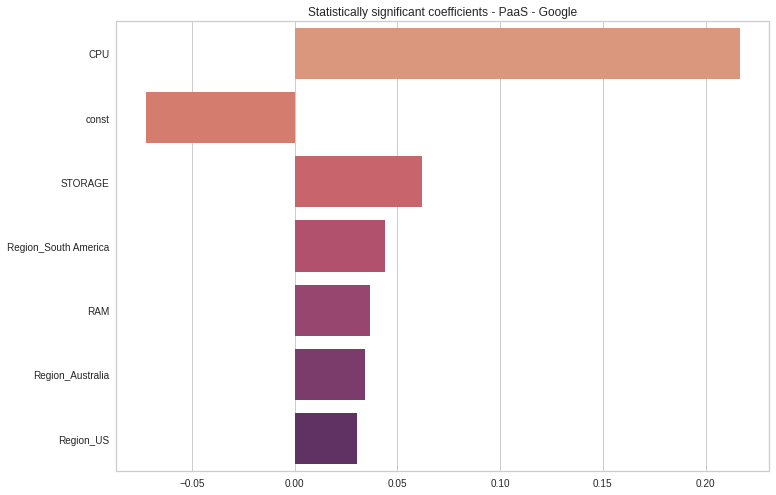

In [64]:

# %% =========================2nd Tornado diagram ======================================
coeff = results.params
coeff = coeff.iloc[(coeff.abs() * -1.0).argsort()]
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(coeff.values, coeff.index, orient='h', ax=ax, palette="flare", capsize=None)
plt.title(f'Statistically significant coefficients - PaaS - {cloudProvider}', fontdict=None, loc='center', pad=None)
plt.savefig(f'plots/paas_significant_coeff_tornado_{cloudProvider}.png')
plt.show()

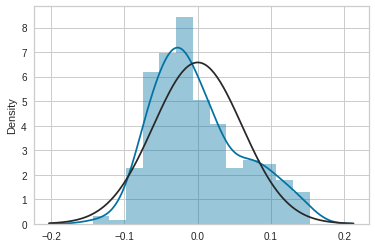

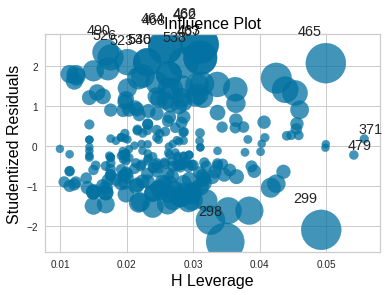

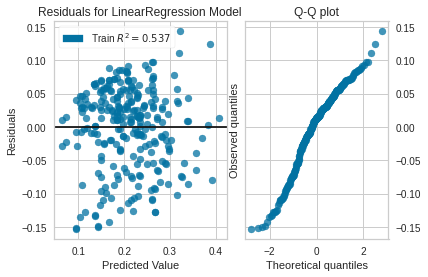

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [65]:
# %% ====== Visualizations for evaluation purposes ===========================
sns.distplot(results.resid, fit=stats.norm, hist=True)
plt.show()

sm.graphics.influence_plot(results, size=40, criterion='cooks', plot_alpha=0.75, ax=None)
plt.show()

visualizer = ResidualsPlot(model, hist=False, qqplot=True)
visualizer.fit(x, y)
# visualizer.score(x_test, y_test)
visualizer.show()

# %%
